<a href="https://colab.research.google.com/github/sridevibonthu/EVA4Phase2/blob/master/Session2/EVAP2S2_Assignment2_V4_torchdowngrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 28kB/s 
     |████████████████████████████████| 6.5MB 1.8MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
!git clone https://github.com/sridevibonthu/EVALibrary.git
import sys
sys.path.append("/content/EVALibrary/EVA4")

Cloning into 'EVALibrary'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 219 (delta 19), reused 0 (delta 0), pack-reused 160
Receiving objects: 100% (219/219), 2.41 MiB | 13.25 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
import random
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%%time
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/EVA4/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.73 s, sys: 1.11 s, total: 2.84 s
Wall time: 4.66 s


#### Data in zip file is moved to a folder.
1. A dataset is created as a shuffled list containing path of the file and the class id

2. created dataset list is split into 70-30


In [ ]:
#step 1
def prepareData(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root+"/"+classes[i]+"/"
    xy = [[path+f, (i)] for f in os.listdir(path)]
    finaldata.extend(xy)
  random.shuffle(finaldata)
  return finaldata


In [ ]:
class_names = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
short_class_names = ['Birds', 'LargeQ', 'SmallQ', 'WingD']
dataset = prepareData("./Data", class_names)
print(f'Dataset Size : {len(dataset)}')
trainlen = int(len(dataset)*0.7)
print(f'Trainset size : {trainlen},  Testset size : {len(dataset)-trainlen}')
print(f'Sample Records {dataset[1:4]}')


Dataset Size : 19318
Trainset size : 13522,  Testset size : 5796
Sample Records [['./Data/Large QuadCopters/img02777.jpg', 1], ['./Data/Winged Drones/img02230.jpg', 3], ['./Data/Winged Drones/img00442.jpg', 3]]


In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-iypego47
All libraries are successfully installed!


In [ ]:
import cv2
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms
# The values here are elsewhere calculated
channel_means = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=4, max_h_size=32, max_w_size=32) # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Resize(224, 224),
                                           A.Normalize(mean=channel_means, std=channel_stdevs)])



In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data, transform=None):
    self.images, self.labels = zip(*data)
    self.transform = transform
    
  def __len__(self):
    return len(self.images)
    
  def __getitem__(self, index):
    if torch.is_tensor(index):
            index = index.tolist()
    image = Image.open(self.images[index])
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

In [ ]:
train = CustomDataset(dataset[:trainlen],  train_transforms)
test = CustomDataset(dataset[trainlen:], test_transforms)
print(len(train), len(test))

13522 5796


In [ ]:
batch_size=32
import eva4dataloaders
dataloader = eva4dataloaders.DataLoader(batch_size=32)
# train dataloader
train_loader = dataloader.load(train)
# test dataloader
test_loader = dataloader.load(test)

In [ ]:
print(type(train[0]))
print(type(train))
print(train[0][0].shape)
print(f'No.of batches :{len(train_loader)}')

<class 'tuple'>
<class '__main__.CustomDataset'>
torch.Size([3, 224, 224])
No.of batches :423


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
torch.Size([32])
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)
(3, 224, 224)


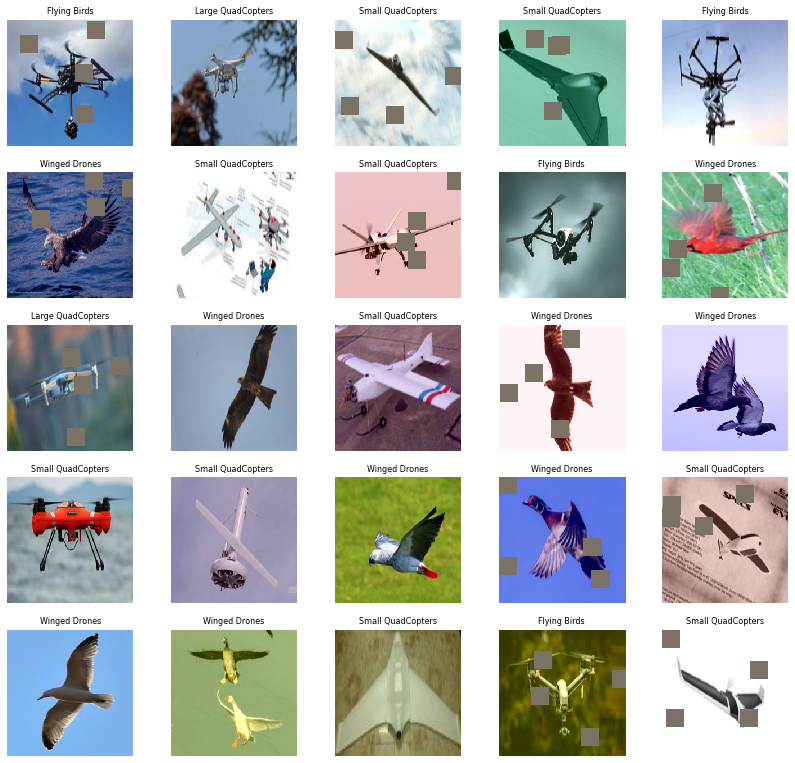

In [ ]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax = plt.subplot(r, c, idx+1)
    ax.set_title(class_names[labels[idx]-1][:30], fontdict={'fontsize': 8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation='none')
plt.show()

In [ ]:
from tqdm import tqdm
import numpy as np

class ModelTrain():
  def __init__(self):
    #to monitor training and test losses
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_epoch_end = []
    
    # initialize tracker for minimum validation loss
    self.valid_loss_min = np.Inf # set initial "min" to infinity

  def train(self, model, device, train_loader, criterion, optimizer, epoch,scheduler,  L1lambda=None):
    model.train()    # prep model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    #print("Entered to training process....")
    for batch_idx, (data, target) in enumerate(pbar):
      #print("Device ", device)
      
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()    
      y_pred = model(data)   # forward pass: compute predicted outputs by passing inputs to the model
      # Calculate loss
      loss = criterion(y_pred, target)
            
      train_loss += loss
      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      
      optimizer.step()   # perform a single optimization step (parameter update)
            # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(train_loss/len(train_loader.dataset))


  ####VAlidate the model ####
  def test(self, model, device, test_loader, criterion,filename):
    #valid_loss_min = np.Inf
    model.eval()  # prep model for evaluation
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += criterion(output, target)  # sum up batch loss
            #test_loss += criterion(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        self.valid_loss_min,
        test_loss))
        torch.save(model.state_dict(), filename)
        self.valid_loss_min = test_loss

In [ ]:
model = models.mobilenet_v2(pretrained=True)
# Freeze model weights

for param in model.parameters():
  param.requires_grad = False
for name, child in model.named_children():
  print(name)
inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(nn.Linear(inputs, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.25),
                                 nn.Linear(256, num_classes))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth



features
classifier


In [ ]:
for name, child in model.features.named_children():
  if name in ['17', '18']:
    print("Layer ", name , " of features stack is unforzen")
    for param in child.parameters():
      param.requires_grad = True

Layer  17  of features stack is unforzen
Layer  18  of features stack is unforzen


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
from torchsummary import summary
summary(model, (3,224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from torch.optim.lr_scheduler import OneCycleLR

#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=25)
criterion = nn.CrossEntropyLoss()
transfer_model = ModelTrain()
EPOCHS = 25
for epoch in range(EPOCHS):
    print("\nEPOCH:", epoch)
    transfer_model.train(model, device, train_loader, criterion, optimizer, epoch, scheduler)
    transfer_model.test(model, device, test_loader, criterion, "tlmodel.pt")

  0%|          | 0/423 [00:00<?, ?it/s]


EPOCH: 0


Loss=0.31434038281440735 Batch_id=422 Accuracy=68.44: 100%|██████████| 423/423 [00:23<00:00, 17.73it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0152, Accuracy: 4605/5796 (79.45%)

Validation loss decreased (inf --> 0.015159).  Saving model ...

EPOCH: 1


Loss=0.6434177160263062 Batch_id=422 Accuracy=78.07: 100%|██████████| 423/423 [00:23<00:00, 17.90it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 4815/5796 (83.07%)

Validation loss decreased (0.015159 --> 0.013119).  Saving model ...

EPOCH: 2


Loss=0.9064871668815613 Batch_id=422 Accuracy=79.42: 100%|██████████| 423/423 [00:23<00:00, 17.92it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 4846/5796 (83.61%)

Validation loss decreased (0.013119 --> 0.012560).  Saving model ...

EPOCH: 3


Loss=0.6175329685211182 Batch_id=422 Accuracy=80.39: 100%|██████████| 423/423 [00:23<00:00, 17.89it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 4880/5796 (84.20%)

Validation loss decreased (0.012560 --> 0.012378).  Saving model ...

EPOCH: 4


Loss=0.46569544076919556 Batch_id=422 Accuracy=81.10: 100%|██████████| 423/423 [00:23<00:00, 17.95it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 4853/5796 (83.73%)


EPOCH: 5


  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 4925/5796 (84.97%)

Validation loss decreased (0.012378 --> 0.012111).  Saving model ...

EPOCH: 6


Loss=0.256706178188324 Batch_id=422 Accuracy=82.89: 100%|██████████| 423/423 [00:23<00:00, 17.67it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 4922/5796 (84.92%)

Validation loss decreased (0.012111 --> 0.011989).  Saving model ...

EPOCH: 7


Loss=0.3463433086872101 Batch_id=422 Accuracy=83.27: 100%|██████████| 423/423 [00:23<00:00, 17.83it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 4960/5796 (85.58%)

Validation loss decreased (0.011989 --> 0.011538).  Saving model ...

EPOCH: 8


Loss=0.5223451852798462 Batch_id=422 Accuracy=83.40: 100%|██████████| 423/423 [00:23<00:00, 17.71it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 4956/5796 (85.51%)

Validation loss decreased (0.011538 --> 0.011119).  Saving model ...

EPOCH: 9


Loss=0.4178951382637024 Batch_id=422 Accuracy=84.34: 100%|██████████| 423/423 [00:23<00:00, 17.73it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 4967/5796 (85.70%)


EPOCH: 10


Loss=0.15935027599334717 Batch_id=422 Accuracy=84.42: 100%|██████████| 423/423 [00:23<00:00, 17.89it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 4998/5796 (86.23%)


EPOCH: 11


Loss=0.551932692527771 Batch_id=422 Accuracy=85.08: 100%|██████████| 423/423 [00:23<00:00, 17.87it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 4984/5796 (85.99%)


EPOCH: 12


Loss=0.29486337304115295 Batch_id=422 Accuracy=85.31: 100%|██████████| 423/423 [00:23<00:00, 17.79it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 5052/5796 (87.16%)

Validation loss decreased (0.011119 --> 0.010846).  Saving model ...

EPOCH: 13


Loss=0.3819965124130249 Batch_id=422 Accuracy=85.76: 100%|██████████| 423/423 [00:23<00:00, 17.71it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 4987/5796 (86.04%)


EPOCH: 14


Loss=0.28722283244132996 Batch_id=422 Accuracy=86.26: 100%|██████████| 423/423 [00:23<00:00, 17.82it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 5073/5796 (87.53%)

Validation loss decreased (0.010846 --> 0.010256).  Saving model ...

EPOCH: 15


Loss=0.17746806144714355 Batch_id=422 Accuracy=86.55: 100%|██████████| 423/423 [00:23<00:00, 17.76it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5052/5796 (87.16%)


EPOCH: 16


Loss=0.18325528502464294 Batch_id=422 Accuracy=87.24: 100%|██████████| 423/423 [00:23<00:00, 17.77it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5037/5796 (86.90%)


EPOCH: 17


Loss=0.61409592628479 Batch_id=422 Accuracy=87.72: 100%|██████████| 423/423 [00:23<00:00, 17.76it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5078/5796 (87.61%)


EPOCH: 18


Loss=0.16333776712417603 Batch_id=422 Accuracy=87.92: 100%|██████████| 423/423 [00:23<00:00, 17.94it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 5060/5796 (87.30%)


EPOCH: 19


Loss=0.7473390102386475 Batch_id=422 Accuracy=88.37: 100%|██████████| 423/423 [00:23<00:00, 17.77it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 5083/5796 (87.70%)


EPOCH: 20


Loss=0.39185020327568054 Batch_id=422 Accuracy=88.96: 100%|██████████| 423/423 [00:23<00:00, 17.95it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 5057/5796 (87.25%)


EPOCH: 21


Loss=0.34293973445892334 Batch_id=422 Accuracy=89.44: 100%|██████████| 423/423 [00:23<00:00, 17.85it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5092/5796 (87.85%)


EPOCH: 22


Loss=0.29947853088378906 Batch_id=422 Accuracy=89.82: 100%|██████████| 423/423 [00:24<00:00, 17.31it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5074/5796 (87.54%)


EPOCH: 23


Loss=0.10801728814840317 Batch_id=422 Accuracy=89.77: 100%|██████████| 423/423 [00:24<00:00, 17.44it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5084/5796 (87.72%)


EPOCH: 24


Loss=0.4504591226577759 Batch_id=422 Accuracy=90.11: 100%|██████████| 423/423 [00:24<00:00, 17.25it/s]



Test set: Average loss: 0.0108, Accuracy: 5092/5796 (87.85%)



In [ ]:
def misclassified(model, testloader, classid=0):
  misclassified_images = []
  model.eval()
  with torch.no_grad():
    for data, target in testloader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim =1, keepdim=True)
      is_correct = pred.eq(target.view_as(pred))
      
      misclassified_inds = (is_correct==0).nonzero()[:,0]
      for mis_ind in misclassified_inds:
        if len(misclassified_images) == 10:
          break
        if(target[mis_ind].item()==classid):
          misclassified_images.append({"target": target[mis_ind].cpu().numpy(), "pred": pred[mis_ind][0].cpu().numpy(),"img": data[mis_ind]})
    return misclassified_images

Wrong predictions of  Flying Birds - short name -  Birds


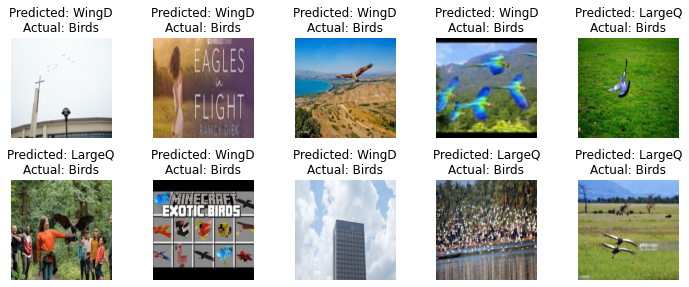

In [ ]:
import plots
print('Wrong predictions of ' , class_names[0], '- short name - ', short_class_names[0])
plots.plot_images(misclassified(model, test_loader, classid=0), short_class_names, "misclassified_birds.png", mean=list(channel_means), std=list(channel_stdevs))

Wrong predictions of  Large QuadCopters - short name -  LargeQ


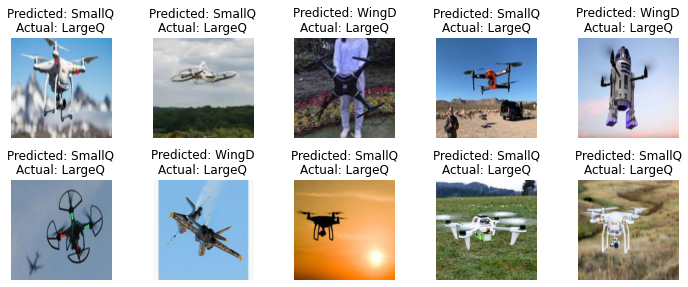

In [ ]:
print('Wrong predictions of ' , class_names[1], '- short name - ', short_class_names[1])
plots.plot_images(misclassified(model, test_loader, classid=1), short_class_names, "misclassified_Large_Qcopters.png", mean=list(channel_means), std=list(channel_stdevs))

Wrong predictions of  Small QuadCopters - short name -  SmallQ


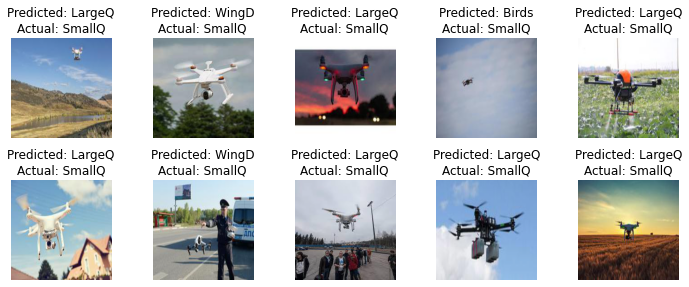

In [ ]:
print('Wrong predictions of ' , class_names[2], '- short name - ', short_class_names[2])
plots.plot_images(misclassified(model, test_loader, classid=2), short_class_names, "misclassified_Small_Qcopters.png", mean=list(channel_means), std=list(channel_stdevs))

Wrong predictions of  Winged Drones - short name -  WingD


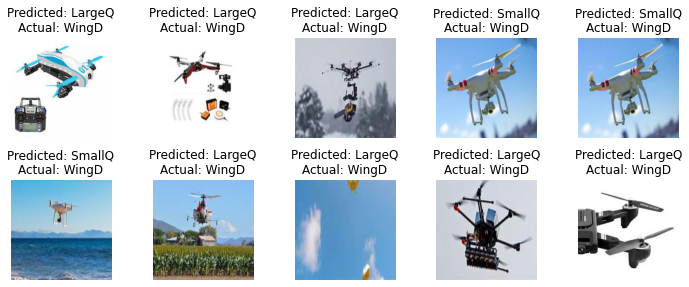

In [ ]:
print('Wrong predictions of ' , class_names[3], '- short name - ', short_class_names[3])
plots.plot_images(misclassified(model, test_loader, classid=3), short_class_names, "misclassified_WingedDrones.png", mean=list(channel_means), std=list(channel_stdevs))

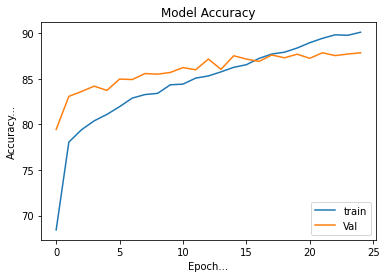

In [ ]:
plt.plot(transfer_model.train_epoch_end)
plt.plot(transfer_model.test_acc)
plt.title("Model Accuracy")
plt.xlabel("Epoch...")
plt.ylabel("Accuracy...")
plt.legend(['train', 'Val'], loc='lower right')
plt.show()

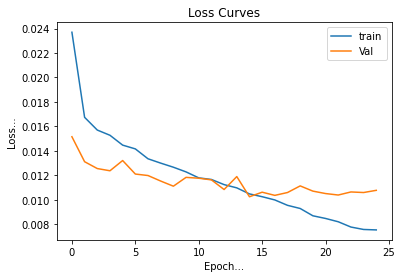

In [ ]:
plt.plot(transfer_model.train_losses)
plt.plot(transfer_model.test_losses)
plt.title("Loss Curves")
plt.xlabel("Epoch...")
plt.ylabel("Loss...")
plt.legend(['train', 'Val'], loc='upper right')
plt.show()

In [ ]:
model.to('cpu')
model.eval()
traced_model = torch.jit.trace(model, torch.randn(1,3,224,224))
traced_model.save('mobilenet_transferlearning.pt')
print("Model saved")


Model saved


In [ ]:
model.to('cpu')
torch.save(model, "tempmodel.pt")

In [ ]:
model = torch.load("tempmodel.pt")
model.eval()

traced_model = torch.jit.trace(model, torch.randn(1,3,224,224))
traced_model.save('mobilenet_transferlearning.pt')
print("Model saved")

Model saved
